Name : Ng Chen Ting 
# Part B
## Task 2 - Data Visualisation
## Question 1 -  Streaming data visualisation

In [ ]:
pip install folium

In [14]:
from time import sleep
from kafka3 import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
from json import loads
import folium

# For inline display of graphs in Jupyter Notebook
%matplotlib notebook

<IPython.core.display.Javascript object>


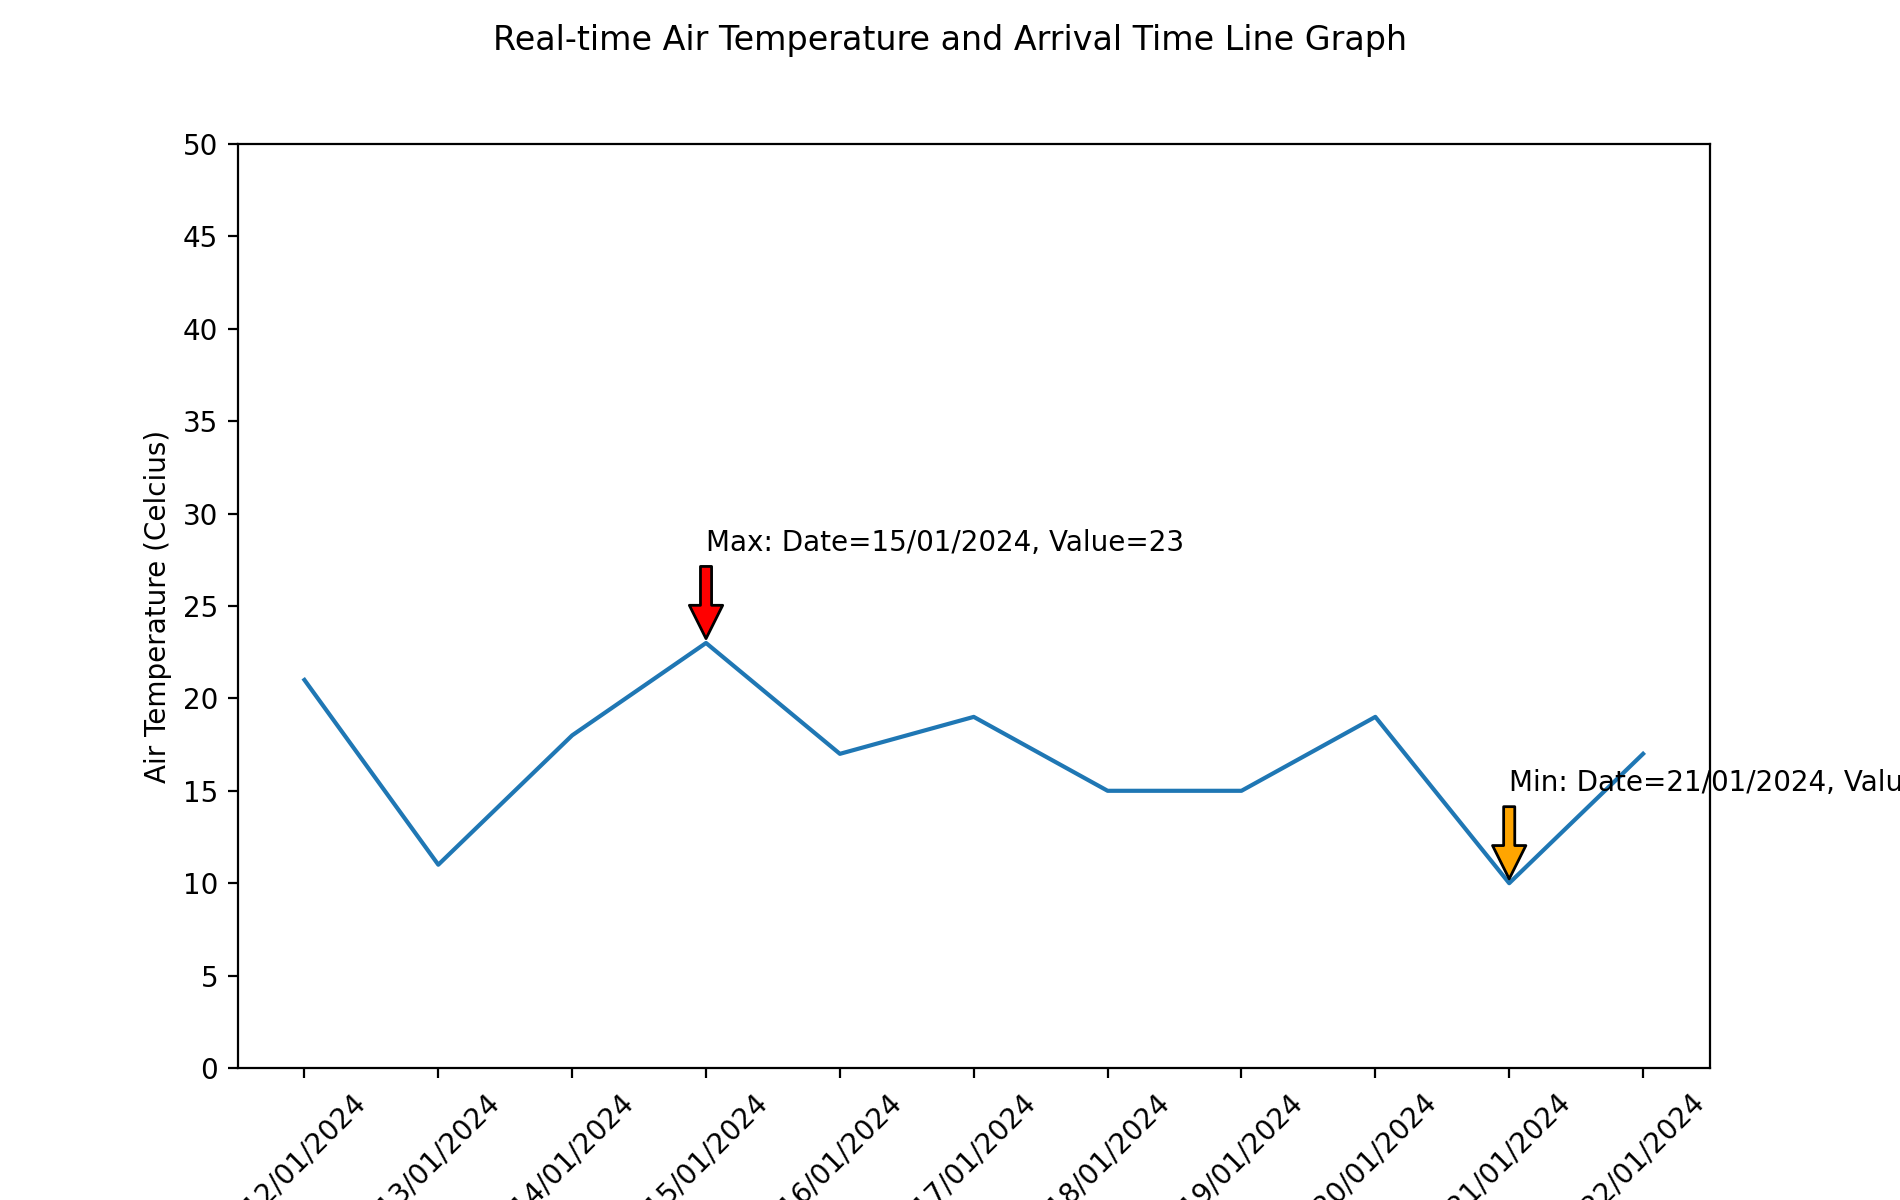

KeyboardInterrupt: 

In [17]:
topic = 'Assignment_TaskB_Climate'
hostip = "192.168.1.14" 

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Date={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Date={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000,       # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest',    # To consume earliest available message
                                   bootstrap_servers=[f'{hostip}:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width, height))
        ax = fig.add_subplot(111)
        fig.suptitle('Real-time Air Temperature and Arrival Time Line Graph')
        fig.show()
        fig.canvas.draw()
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        x, y = [], []
        for message in consumer:
            msg_value = message.value.decode('utf-8')     # Decoding bytes to string
            data = loads(msg_value)                       # Parsing JSON string to Python dictionary
            date_value = data["date"]                     # Extracting the value associated with the "date" key
            x.append(date_value)                          # Append x & y values to arrays
            y.append(data['air_temperature_celcius'])
            
            # Start plotting when we have 10 data points
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y) # Plot all x & y values.
                ax.set_xlabel('Arrival Time')
                ax.set_ylabel('Air Temperature (Celcius)')
                ax.set_ylim(0, 50)
                ax.set_yticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
                annotate_max(x,y)
                annotate_min(x,y)
                ax.tick_params(axis='x', labelrotation=45) # Rotate dates
                fig.canvas.draw()
                
                # Pop the oldest value to make room for the new value.
                x.pop(0)
                y.pop(0)
                
    except Exception as ex:
        print(str(ex))
    
    
if __name__ == '__main__':
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)

## Question 2 -  Static data visualisation

In [4]:
import pymongo
from datetime import datetime
from pymongo import MongoClient

client = MongoClient('192.168.1.14', 27017) 
db = client["fit3182_assignment_db"] 
climate_collection = db["Assignment_2_Climates"]

### Part a

<IPython.core.display.Javascript object>


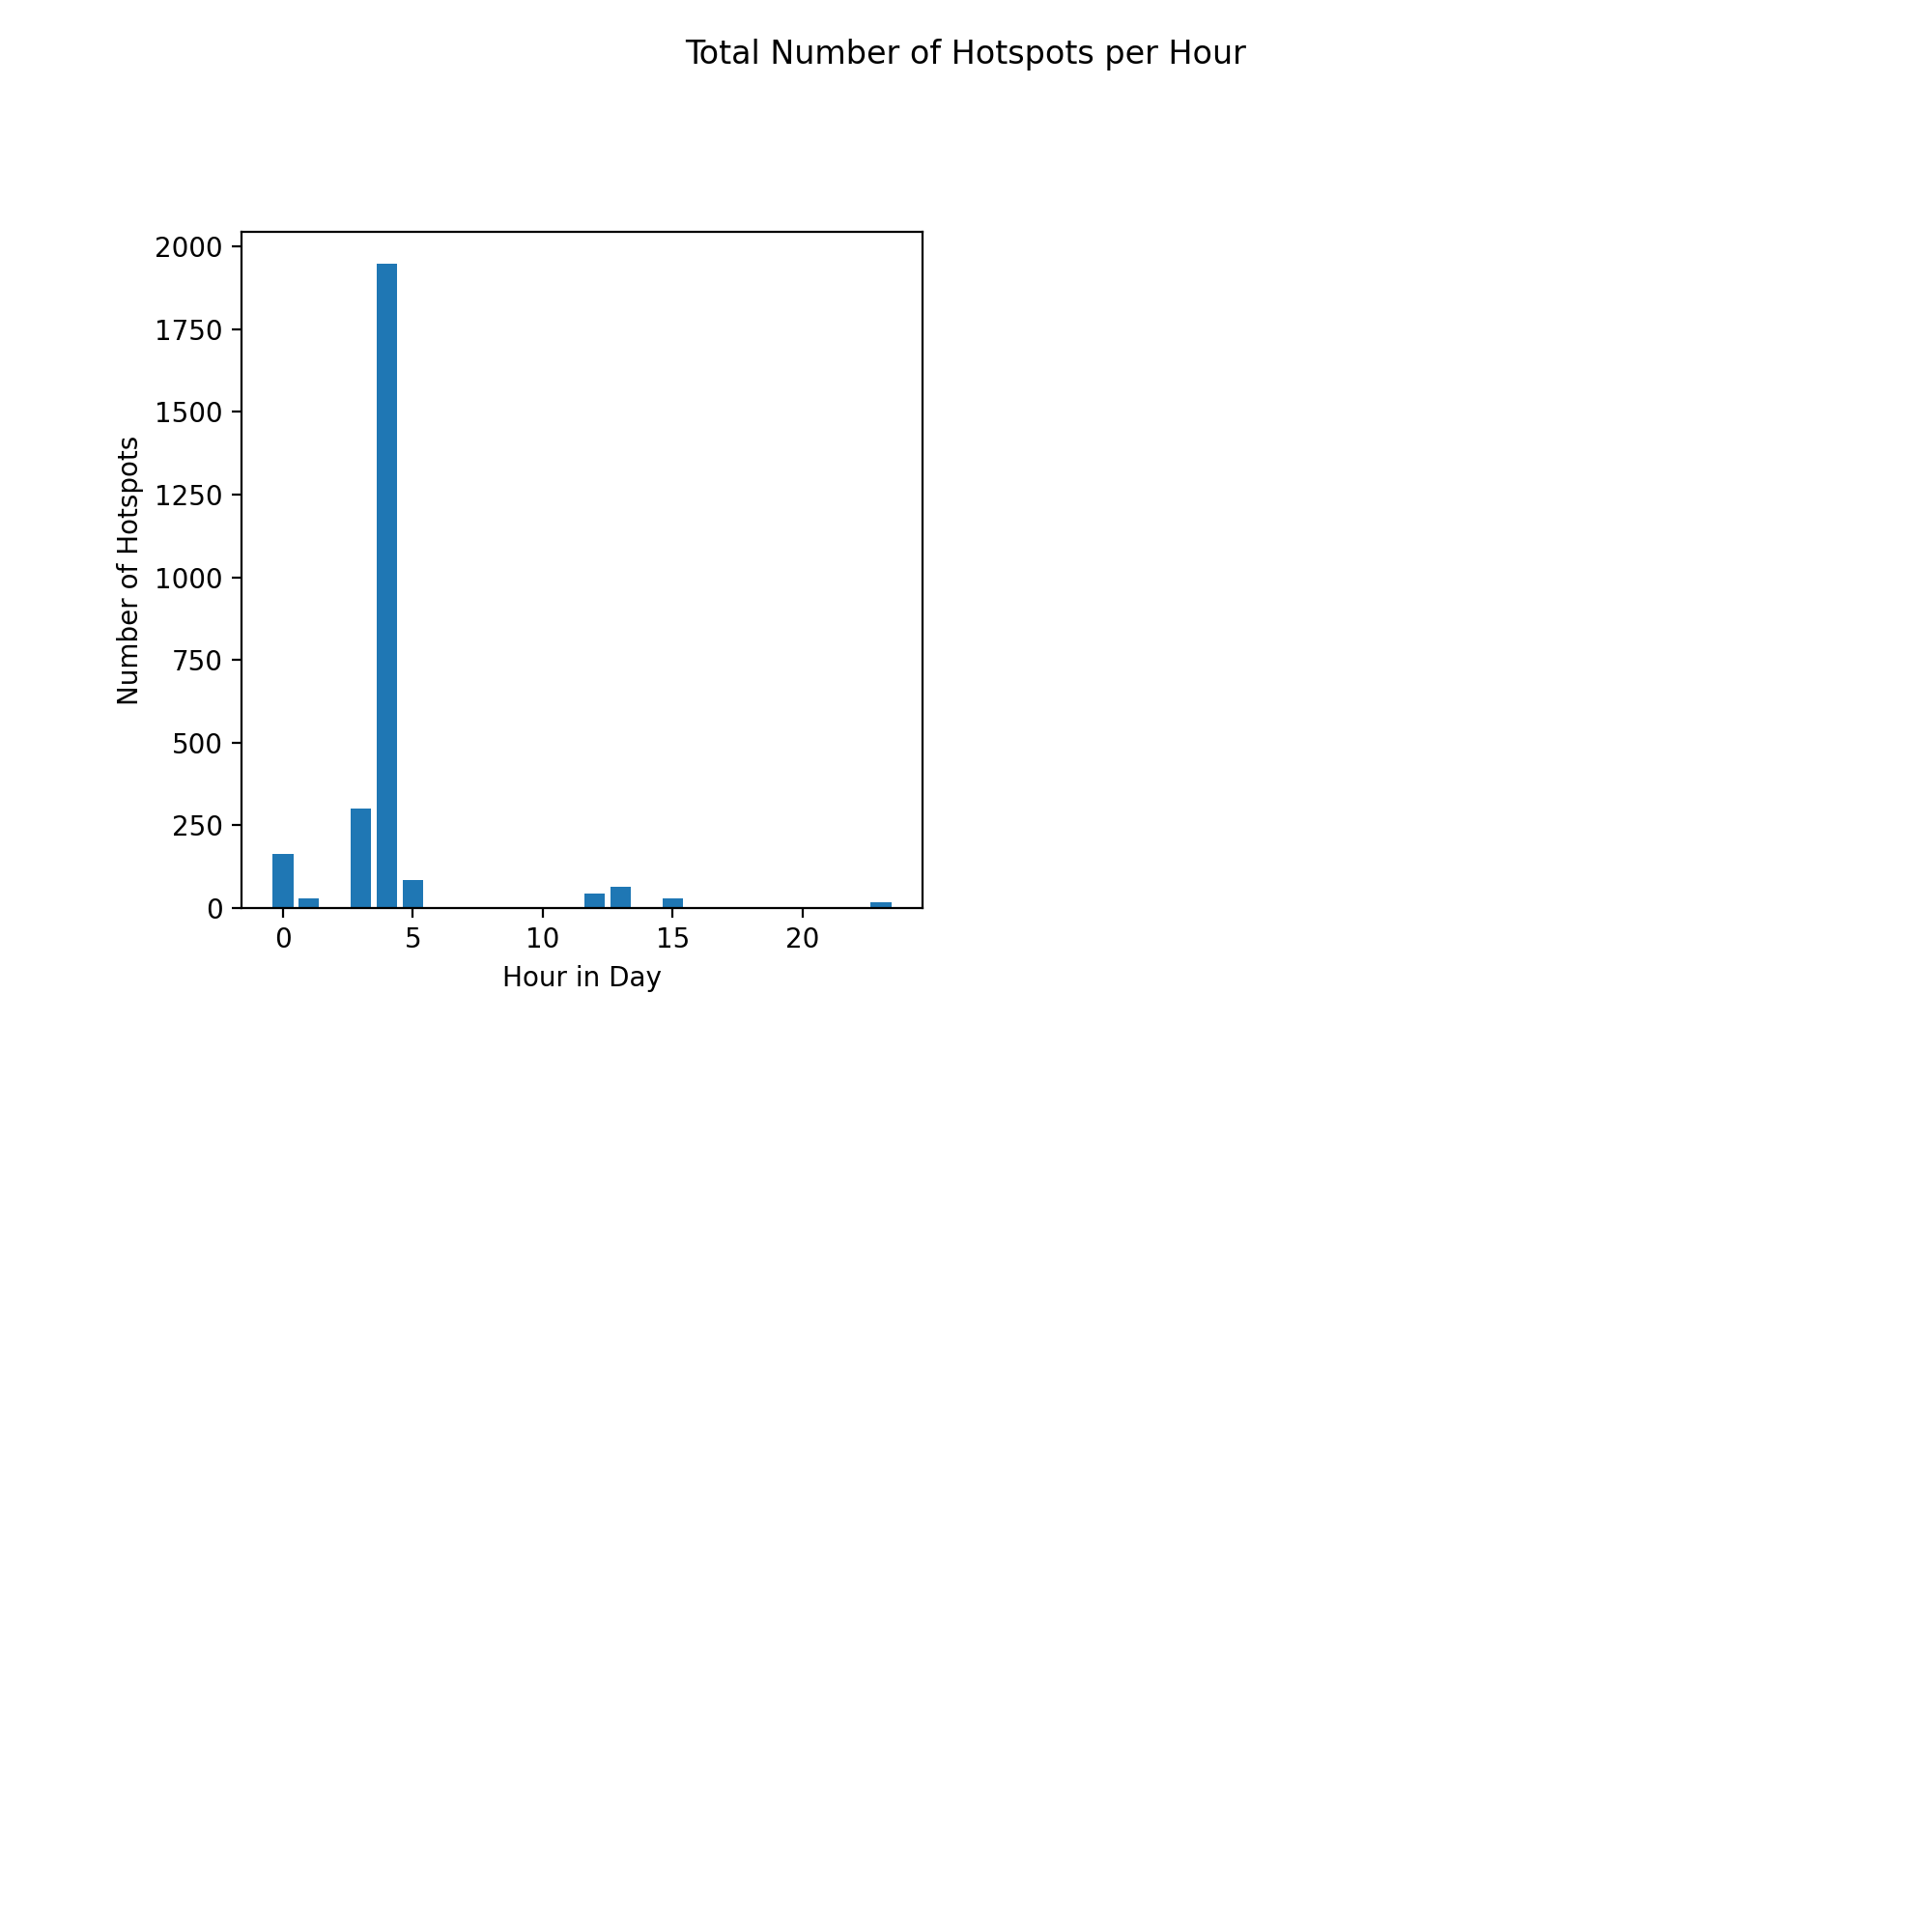

In [13]:
# Collect all hotspots from the database
result = climate_collection.aggregate([
    {'$unwind': '$hotspots'},
    {'$project': {
        '_id': 0, 
        'hotspots.time': 1
    }}
])

# Create a bucket array for each hour of the day.
hour_data = [[0] for x in range(24)]

# For each time, increment count in relative hour bucket.
for each in result:
    hour = int(each['hotspots']['time'].strftime('%H'))
    count = hour_data[hour][0] + 1
    hour_data[hour][0] = count
    
x, y = [], []

# Add each hour count & hour the relative x & y axis
for i in range(0, len(hour_data)):
    y.append(hour_data[i][0])
    x.append(i)

width = 10
height = 10

fig = plt.figure(figsize=(width, height))
fig.suptitle('Total Number of Hotspots per Hour')
ax = fig.add_subplot(221)
ax.bar(x, y)
ax.set_xlabel('Hour in Day')
ax.set_ylabel('Number of Hotspots')

fig.show()
fig.canvas.draw()

### Part b

In [18]:
start_date = datetime(2024, 1, 2)
climate_result = climate_collection.find({"date": {"$gt": start_date}})

m = folium.Map(location=[-37, 140], zoom_start=7)

# For each climate
for climate in climate_result:
    for hotspot in climate["hotspots"]:
    
        # Get data required for climate
        air_temperature = climate['air_temperature_celcius']
        relative_humidity = climate['relative_humidity']
    
        # Get data required for hotspot location & associated pop-up information.
        cause = hotspot['cause']
        longitude = hotspot['longitude']
        latitude = hotspot['latitude']
        surface_temperature = hotspot['surface_temperature_celcius']

        # HTML string for pop-up details
        html_string = f"<html><body><table><tr><th>Air Temp: </th><td>{air_temperature}</td></tr><tr><th>Surface Temp: </th><td>{surface_temperature}</td></tr><tr><th>Relative Humidity: </th><td>{relative_humidity}</td></tr><tr><th>Cause: </th><td>{cause}</td></tr></table></body></html>"

         # If natural, add blue marker, else use red.
        if cause == 'natural':
            folium.Marker(
                location=[latitude, longitude],
                popup=folium.Popup(html=html_string, max_width='100%'),
                icon=folium.Icon(color="blue", icon="info-sign"),
            ).add_to(m)
        else:
            folium.Marker(
                location=[latitude, longitude],
                popup=folium.Popup(html=html_string, max_width='100%'),
                icon=folium.Icon(color="red", icon="info-sign"),
            ).add_to(m)

m